# 예지 보수 Predictive Maintenance (PM)

- 보수의 종류
  > 고장 후 보수: 기기가 고장이 나면 보수를 하는 것   
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것    
  > 예지 보수: 고장을 예측하여 적절한 시점에 보수를 하는 것    
- 예제
 - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측
 
- 특성 추가로 성능 향상

## PM 회귀 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

## PM 분류 모델 (다중  분류)
- U (Unsafe): 위험한 상태를 2개 이상으로 분류
- U 값이 0/1/2 세가지를 갖는 다중 분류 모델로 구현

<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.45.50.png?raw=1" align='left'>

## 기본 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [146]:
# from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

## 훈련 데이터
- 스페이스로 구분된 숫자 원시 (raw) 데이터를 데이터프레임으로 읽는다
- 매 사이클별로 항공기 엔진 운영 상태(State) 제공
- 엔진별, 고장 시점까지의 운영 데이터 제공

In [3]:
path = 'http://azuremlsamples.azureml.net/templatedata/PM_train.txt'
data_raw = pd.read_csv(path, sep = ' ', header=None)
print(data_raw.shape)
data_raw[:3]

(20631, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN


### 컬럼 이름은 미리 주어져 있다

In [4]:
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

- 컬럼 (변수) 설명
 -	__id__: 엔진 ID (1~100)
 -	__cycle__: 엔진별 운행 시퀀스 번호, (1~ 고장시점 까지)
 -	__setting1__ to __setting3__: 엔진 운영 설정 변수
 -	__s1__ to __s21__: 센서 값


In [5]:
# 불필요한 컬럼 삭제 (마지막 두 컬럼)
data_raw.drop([26,27], axis=1, inplace=True)

In [6]:
# 컬럼 이름 변경
data_raw.columns = col_names
data_raw[185:195] 
# 엔진 1에서 엔진 2 데이터로 바뀌는 부분이 192행이다

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,520.08,2388.25,8123.45,8.5227,0.03,397,2388,100.0,38.47,23.0564
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,519.53,2388.28,8115.67,8.5218,0.03,396,2388,100.0,38.42,23.0822
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,522.58,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250


In [125]:
data_raw[470:490]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
470,2,279,0.0006,0.0005,100.0,518.67,643.64,1594.80,1426.95,14.62,...,519.66,2388.26,8164.77,8.5237,0.03,395,2388,100.0,38.51,23.0460
471,2,280,-0.0061,-0.0000,100.0,518.67,643.63,1594.21,1422.89,14.62,...,519.91,2388.21,8163.77,8.4889,0.03,396,2388,100.0,38.56,23.1462
472,2,281,-0.0009,-0.0003,100.0,518.67,643.60,1598.25,1424.36,14.62,...,519.48,2388.15,8167.57,8.5377,0.03,398,2388,100.0,38.52,23.0385
473,2,282,0.0012,-0.0000,100.0,518.67,643.94,1598.56,1426.87,14.62,...,520.05,2388.18,8168.43,8.5149,0.03,397,2388,100.0,38.44,23.0940
474,2,283,0.0046,0.0002,100.0,518.67,643.78,1602.03,1429.67,14.62,...,520.07,2388.20,8174.85,8.5199,0.03,398,2388,100.0,38.42,23.0358
475,2,284,-0.0006,0.0001,100.0,518.67,643.91,1601.35,1430.04,14.62,...,519.95,2388.21,8166.83,8.5291,0.03,395,2388,100.0,38.23,23.1196
476,2,285,-0.0007,0.0004,100.0,518.67,643.67,1596.84,1431.17,14.62,...,519.91,2388.22,8164.83,8.5242,0.03,396,2388,100.0,38.39,23.1155
477,2,286,-0.0010,-0.0003,100.0,518.67,643.44,1603.63,1429.57,14.62,...,519.51,2388.22,8169.97,8.4932,0.03,395,2388,100.0,38.33,23.0169
478,2,287,-0.0005,0.0006,100.0,518.67,643.85,1608.50,1430.84,14.62,...,519.81,2388.21,8175.57,8.5365,0.03,398,2388,100.0,38.43,23.0848
479,3,1,0.0008,0.0005,100.0,518.67,642.04,1584.20,1398.13,14.62,...,522.24,2388.00,8138.40,8.4207,0.03,391,2388,100.0,38.96,23.3205


In [8]:
data_raw.shape

(20631, 26)

- 100개의 엔진이 있고 각각 1~362 사이클 실행 정보가 있다.
- 마지막 사이클 번호가 고장난 시점이다.

# 레이블(y) 컬럼 생성
- 회귀 분석에서는 잔여시간(TTF)을 추정하며 각 상태(State)에서 앞으로 남은 잔여시간을 계산한 후 이를 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 얼마 기간 이내에 고장 날지 여부를 예측한다
 - 이진 분류: 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
 - 다중 분류: 예를 들어 30 사이클 이내에 고장이 날지 또는 15 사이클 이내 고장이 날지를 나누어 예측한다 (0/1/2 구분)
- 회귀 및 분류를 위한 레이블을 만들겠다

In [9]:
df = data_raw.copy()

### TTF 구하기
- TTF를 RUL(Remaining Useful Life)라고도 한다
- 잔여수명 (RUL) 컬럼 추가
- 같은 엔진 ID에 대해서 최대값이 "수명"을 나타내므로 이를 먼저 구하고
- 이를 rul 데이터프레임에 저장한다
- 같은 'id'를 같는 행들을 하나의 데이터프레임으로 만드는 groupby를 사용한다

In [10]:
# remaining useful lifetime  (ttf)
rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
rul

,id,cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


- 각 행별로 ttf 값은, 각 엔진별 rul 테이블의 수명에서 현재 시점 cycle 값을 뺀 값이다
- rul 데이터프레임에서 수명을 나타내는 cycle 컬럼 이름을 max라고 바꾸겠다
- 잔여 수명을 나타내는 'ttf' 컬럼을 추가한다

In [11]:
rul.columns = ['id', 'max']
df = df.merge(rul, on=['id'], how='left')
df[:10]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,max
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,192
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,192
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,192
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,192
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,192


In [12]:
df['ttf'] = df['max'] - df['cycle']
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,max,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [13]:
df.drop('max', axis=1, inplace=True)

### 분류용 레이블
- 이진분류를 위해서, 앞으로 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다
 - bnc (binary classifiation)
- 다중 분류를 위해서, 앞으로 30 및 15 사이클 이내에 고장이 날 지를 구분하는 다중 분류용 레이블을 만든다
 - mcc (multi-class classification)

In [14]:
w1 = 30
w2 = 15
df['label_bnc'] = np.where(df['ttf'] <= w1, 1, 0 )
df['label_mcc'] = df['label_bnc']
df.loc[df['ttf'] <= w2, 'label_mcc'] = 2
df[:5]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [15]:
df[173:193]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
173,1,174,-0.0001,-0.0002,100.0,518.67,642.64,1599.81,1422.58,14.62,...,8.4476,0.03,393,2388,100.0,38.57,23.0357,18,1,1
174,1,175,0.0001,0.0002,100.0,518.67,643.61,1603.29,1422.52,14.62,...,8.4890,0.03,394,2388,100.0,38.58,23.1573,17,1,1
175,1,176,-0.0020,-0.0003,100.0,518.67,642.86,1592.27,1422.73,14.62,...,8.4853,0.03,394,2388,100.0,38.72,23.2491,16,1,1
176,1,177,-0.0038,-0.0003,100.0,518.67,643.79,1602.02,1423.99,14.62,...,8.4779,0.03,396,2388,100.0,38.63,23.1673,15,1,2
177,1,178,-0.0001,0.0002,100.0,518.67,643.38,1605.33,1424.65,14.62,...,8.4770,0.03,395,2388,100.0,38.65,23.1770,14,1,2
178,1,179,0.0023,-0.0003,100.0,518.67,642.86,1592.56,1429.45,14.62,...,8.4947,0.03,395,2388,100.0,38.77,23.1888,13,1,2
179,1,180,-0.0024,0.0000,100.0,518.67,643.58,1599.87,1417.14,14.62,...,8.4737,0.03,395,2388,100.0,38.86,23.0070,12,1,2
180,1,181,-0.0006,0.0005,100.0,518.67,643.44,1596.71,1420.64,14.62,...,8.4720,0.03,397,2388,100.0,38.34,23.1652,11,1,2
181,1,182,-0.0010,0.0003,100.0,518.67,644.21,1602.08,1426.62,14.62,...,8.5158,0.03,397,2388,100.0,38.43,23.1787,10,1,2
182,1,183,0.0001,0.0001,100.0,518.67,643.24,1597.23,1419.03,14.62,...,8.5041,0.03,396,2388,100.0,38.56,23.1302,9,1,2


## 스케일링
- 모든 센서 값의 최소, 최대 값이 0~1 범위를 갖도록 스케일링한다 
- 스케일링 대상이 아닌 ['id','cycle','ttf','label_bnc','label_mcc'] 컬럼은 제외하기 위해서 difference 함수를 사용한다

In [16]:
# Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
cols_sc = df.columns.difference(['id','cycle','ttf','label_bnc','label_mcc'])
min_max_scaler = MinMaxScaler()
df[cols_sc] = min_max_scaler.fit_transform(df[cols_sc])
df[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0


# 탐색적 분석
-  전처리된 데이터를 파일에서 읽는다

In [17]:
# 모델 입력(X)으로 사용할 특성을 선택한다 (여기서는 모두 사용)
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [18]:
# ttf와 상관관계가 큰 순으로 소팅해 본다 (방법 1)
df[features].corrwith(df.ttf).sort_values(ascending=False)

s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
dtype: float64

In [19]:
# ttf와의 상관관계가 큰 특성의 리스트
corr_big_features = ['s12', 's7', 's21', 's20', 's6', 's14', 
    's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']

## 상관관계 히트맵

In [20]:
corr_big_features = corr_big_features +  ['ttf']

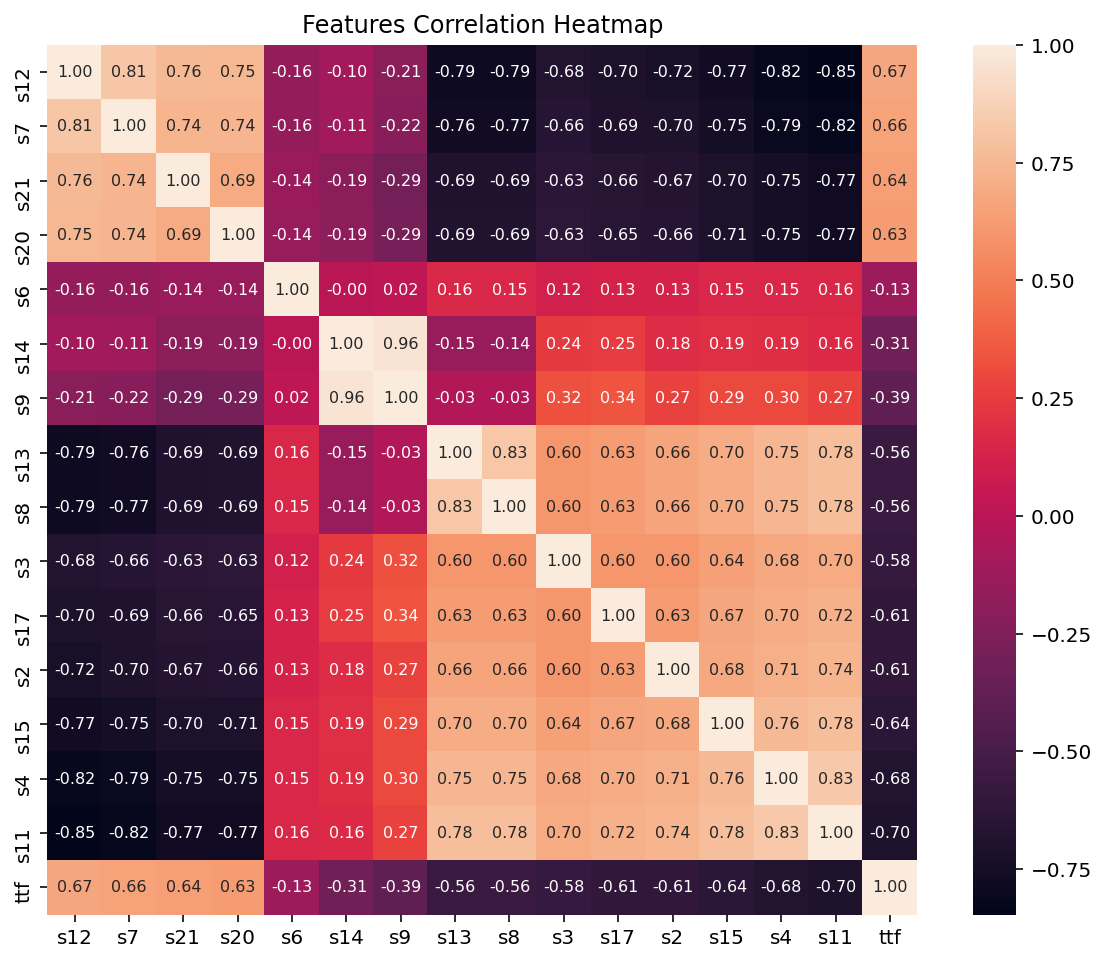

In [21]:
import seaborn as sns
cm = np.corrcoef(df[corr_big_features].values.T)
# sns.set(font_scale=1.0)
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
  annot_kws={'size': 8}, yticklabels=corr_big_features, 
                 xticklabels=corr_big_features)
plt.title('Features Correlation Heatmap')
plt.show()

- 높은 상관관계를 갖는 특성들(> 0.8): (s14, s9), (s11, s4), (s11, s7), (s11, s12), (s4, s12), (s8,s13),  (s7, s12)  
- 이들은 중복 성향이 있어 제거 대상이 될 수 있다.

## 시각화
- 여러 특성의 분포를 파악하는 함수를 정의한다
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기
- 시간에 따른 센서값 변화 보기

In [22]:
def plot_time_series(df, s, N):    
    fig, axes = plt.subplots(N, 1, sharex=True, figsize = (8, 8))
    fig.suptitle(s + ' time series / cycle', fontsize=12)
    
    select_engines = np.random.choice(range(1,101), N, replace=False).tolist()
    
    for e_id in select_engines:
        df2 = df[['cycle', s]][df.id == e_id]
        i = select_engines.index(e_id)
        axes[i].plot(df2['cycle'],df2[s])
        axes[i].set_ylabel('engine ' + str(e_id))
        axes[i].set_xlabel('cycle')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

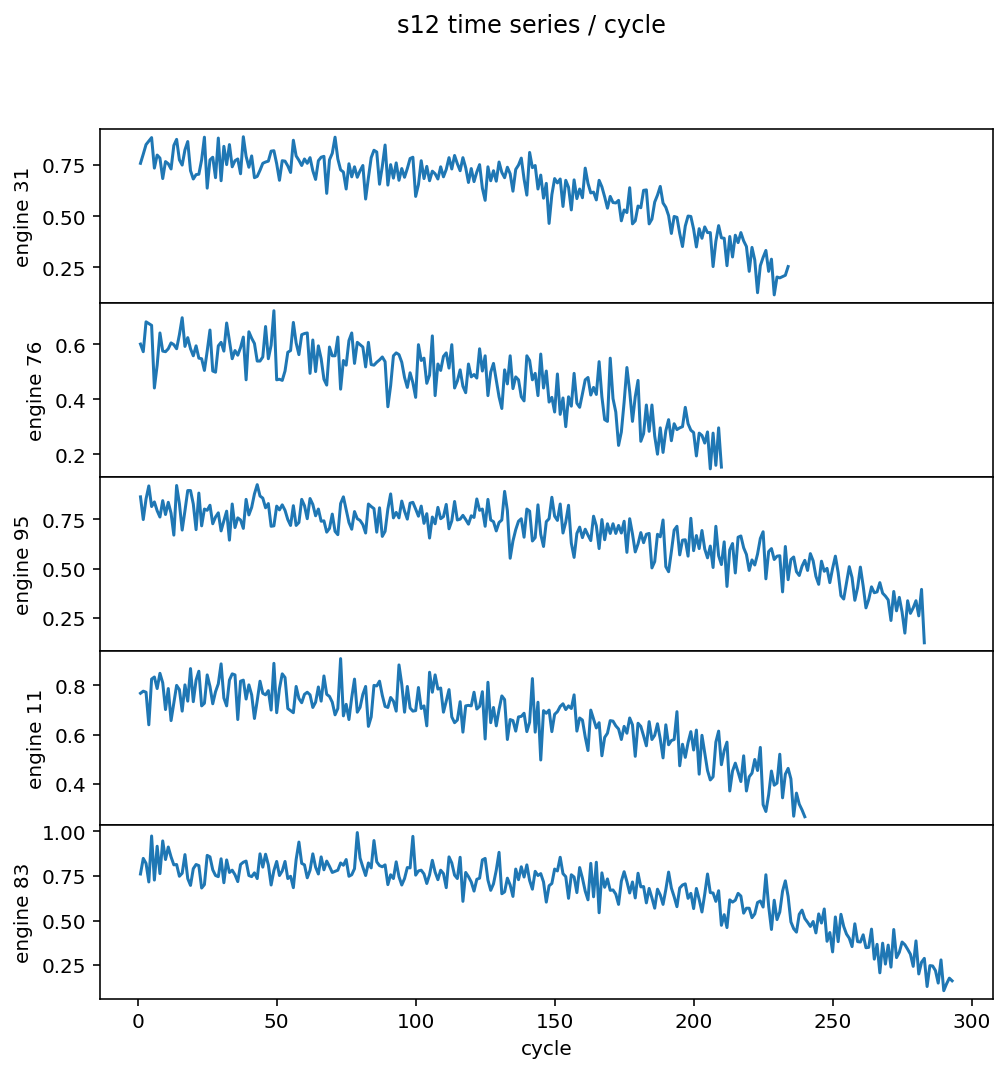

In [23]:
plot_time_series(df, 's12',5)

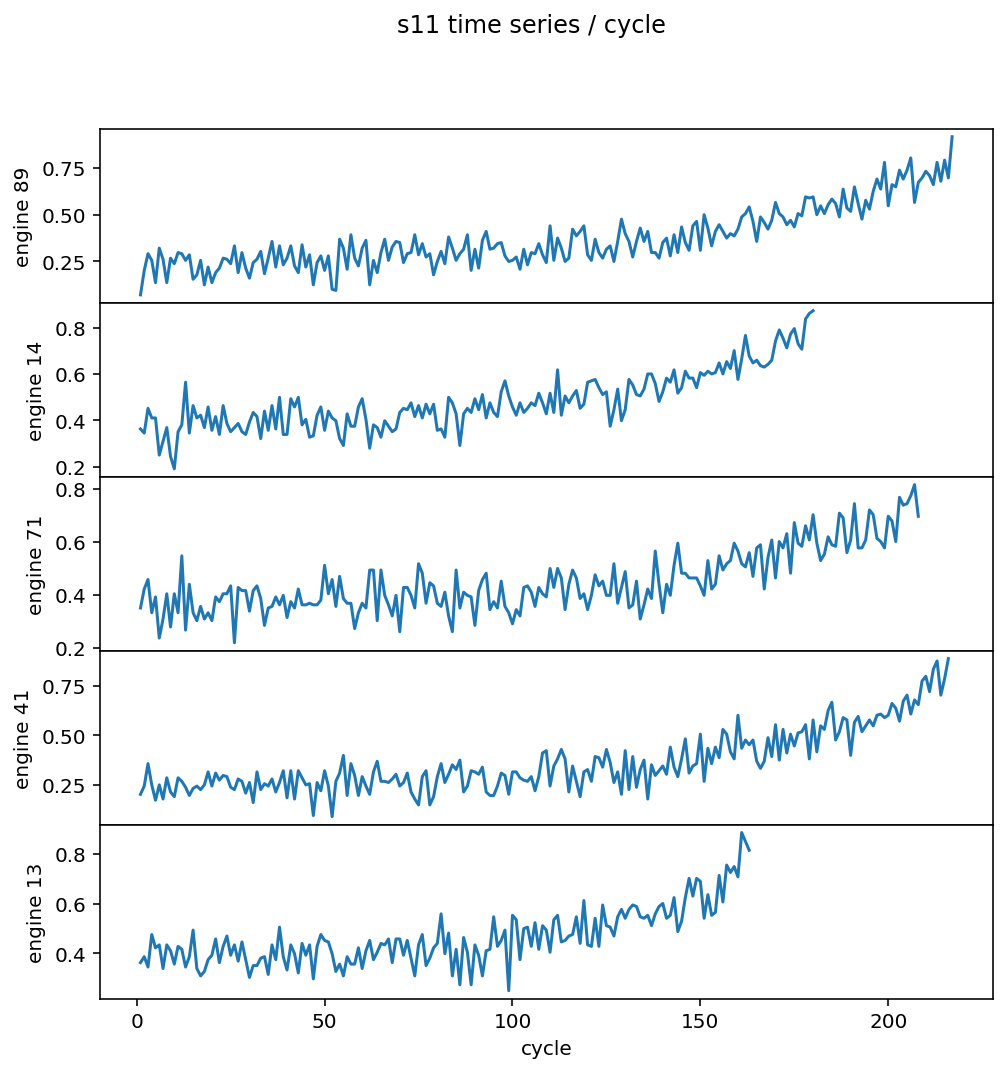

In [24]:
plot_time_series(df, 's11',5)

# 고장시점 예측
- 회귀분석

## 입력(X)과 레이블(y) 설정

In [25]:
X = df[features]
y = df['ttf']

## 훈련데이터 검증 데이터 나누기

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y) # 랜덤하게 섞는다
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15473, 24), (5158, 24), (15473,), (5158,))

## 회귀분석 성능 지표
- RMSE
- MAE
- R squared

In [27]:
def show_regression_result(y_test, y_pred, N=100):
    y_test = y_test.values
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("rmse=", np.sqrt((error**2).mean()).round(4))
    print("max error=", max(error).round(4))
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.-', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

## 상관 계수와 중요 특성값

In [28]:
def plot_features_weights(features, weights):
    W = pd.DataFrame({'Weights':weights}, features)
    fig_size= 6
    if len(features) > 30: fig_size=12
    if len(features) > 40: fig_size=18
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(8,fig_size))
    plt.xlabel('Features Importance/Weights')
    plt.gca().legend_ = None

## 선형 회귀 모델

In [29]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

MAE= 34.2639
rmse= 45.1298
max error= 93.2933
R2= 0.5736


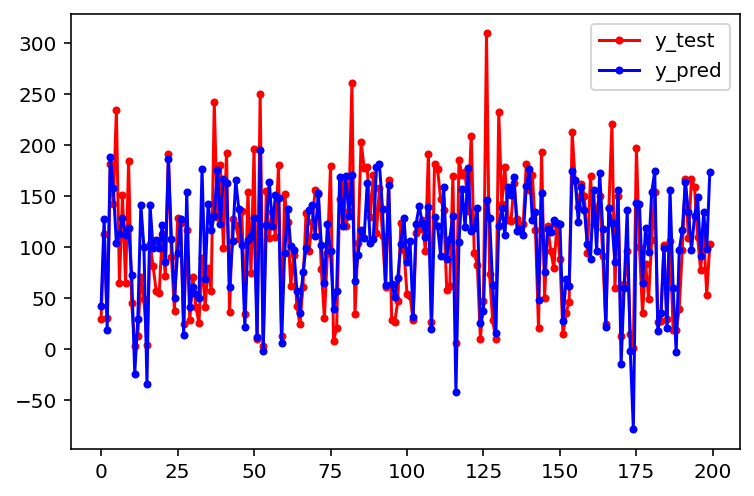

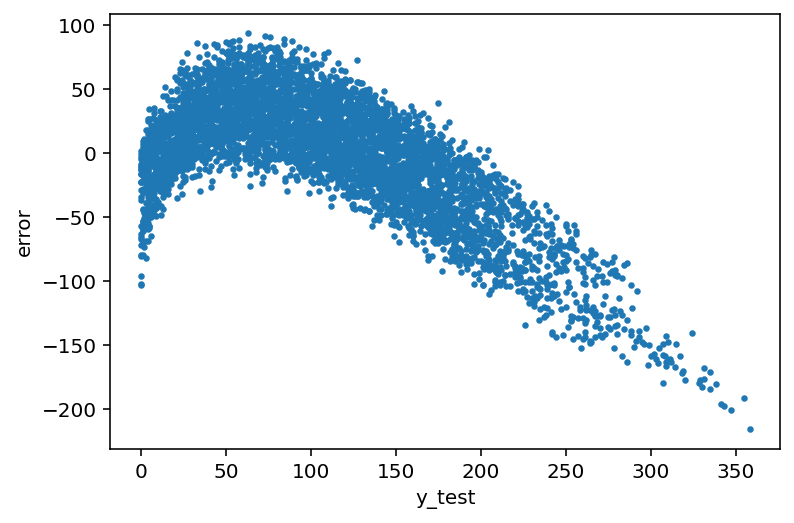

In [30]:
show_regression_result(y_test, y_pred, 200)

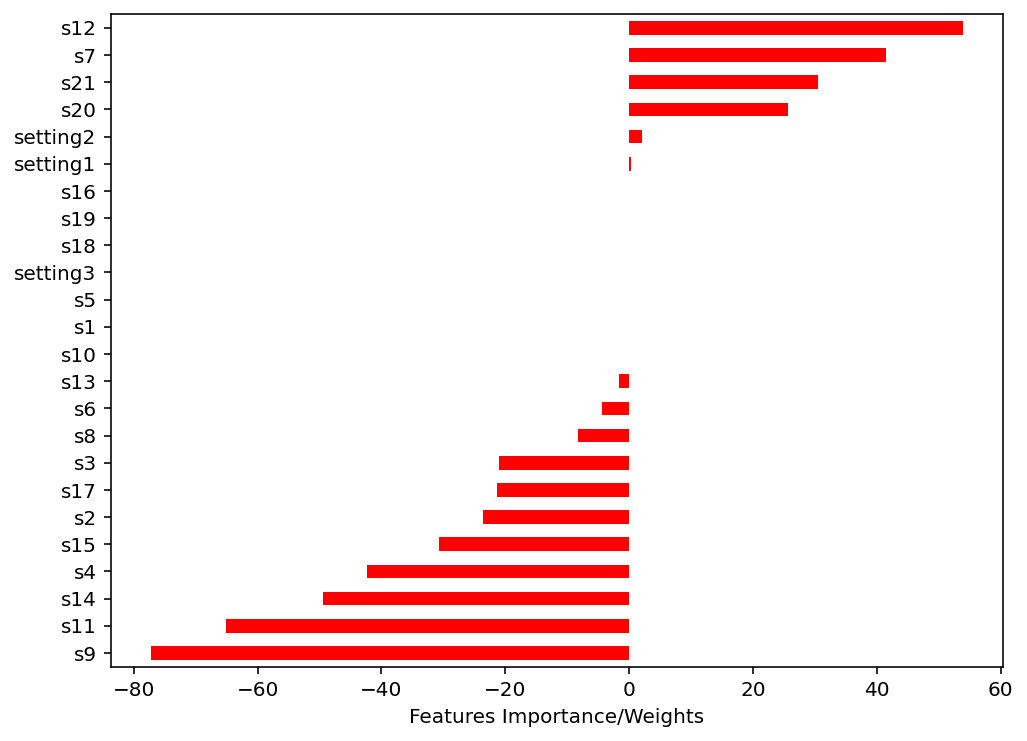

In [31]:
plot_features_weights(X_train.columns, linreg.coef_)
# (방법2: 계수가 큰 특성을 선택할 수 있다)

## 랜덤 포레스트

MAE= 30.1345
rmse= 43.1868
max error= 125.28
R2= 0.6281


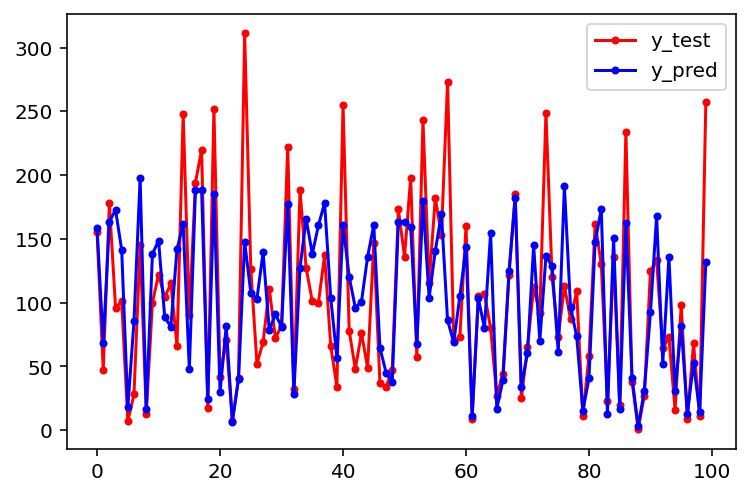

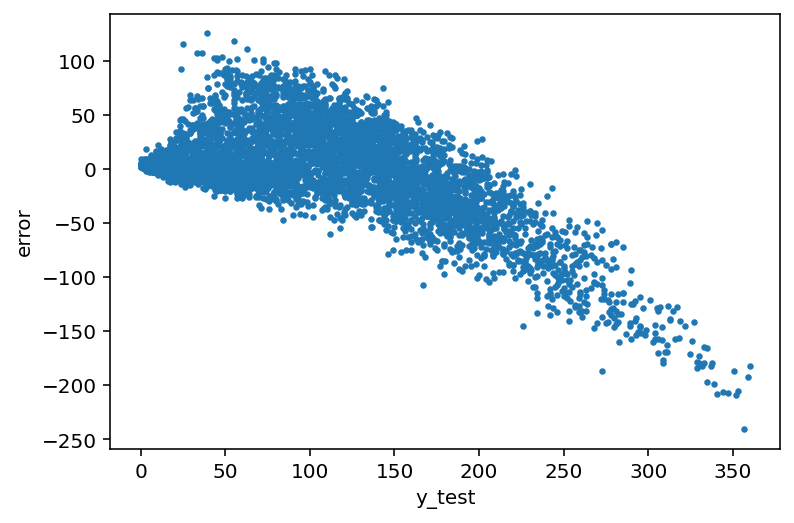

In [126]:
rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_regression_result(y_test, y_pred)

In [33]:
np.vstack((y_test, y_pred)).T

array([[ 29.  ,  40.29],
       [112.  , 129.45],
       [ 30.  ,  23.26],
       ...,
       [208.  , 131.22],
       [149.  , 141.31],
       [189.  , 169.24]])

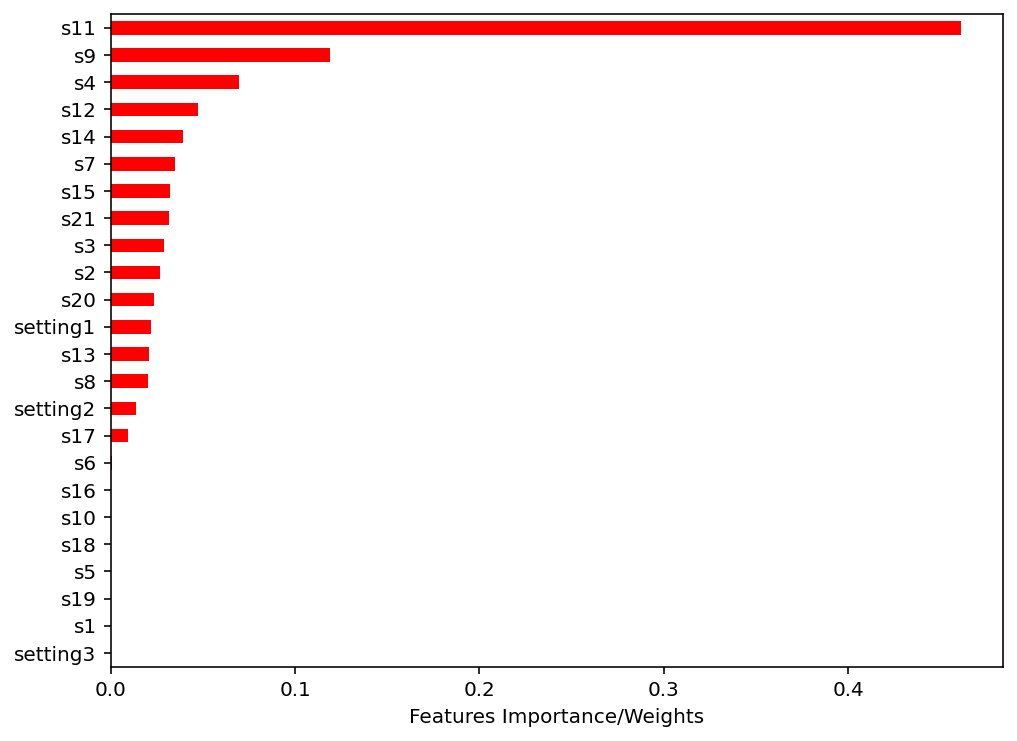

In [35]:
plot_features_weights(X_train.columns, rfr.feature_importances_)
# (방법 3: 특성중요도를 보고 특성 선택)

## LightGBM

- 설치 !conda install lightgbm -y

MAE= 29.9629
rmse= 42.7545
max error= 116.8412
R2= 0.6355


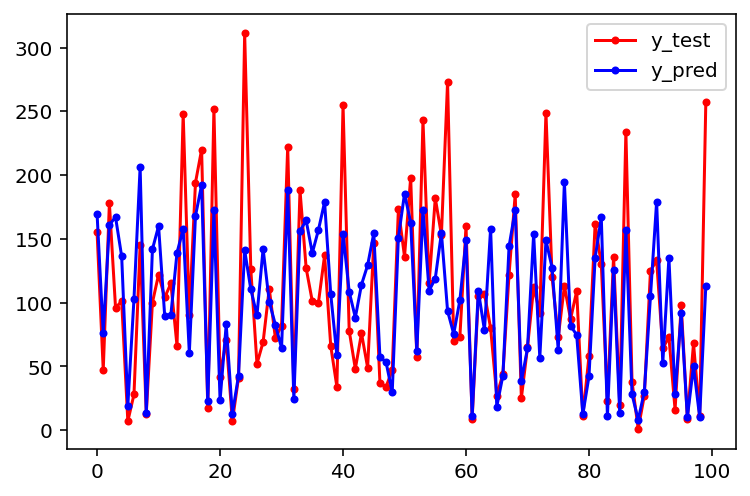

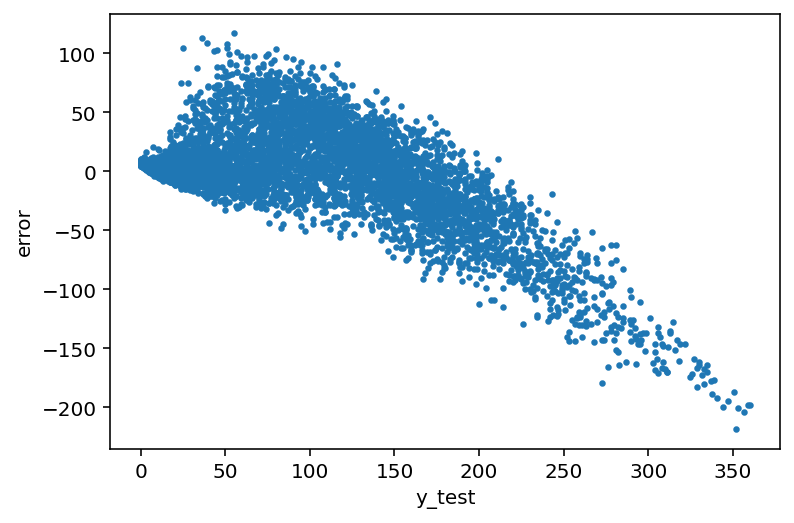

In [137]:
lgbm_r = LGBMRegressor(n_estimators=200)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred)

# PM 이진 분류

In [138]:
X = df[features]
y = df['label_bnc']
X_train, X_test, y_train, y_test = train_test_split(X, y)# 학습 및 검증 데이터 크기 확인

## 로지스틱 회귀

In [139]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 컨퓨전 매트릭스
- 정확도, 정밀도, 리콜, f1점수 보기

In [140]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [141]:
show_clf_result(y_test, y_pred)

[[4316   77]
 [ 107  658]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4393
           1       0.90      0.86      0.88       765

    accuracy                           0.96      5158
   macro avg       0.94      0.92      0.93      5158
weighted avg       0.96      0.96      0.96      5158



### ROC 커브 그리기

In [41]:
def draw_roc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test.values, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

##  분류 경계치 선택
- recall, precision 선택후 결정

In [143]:
(model.predict_proba(X_test)[:,1] < 0.5).sum()

4423

In [142]:
(model.predict_proba(X_test)[:,1] > 0.5).sum()

735

In [47]:
y_pred = model.predict_proba(X_test)[:,1] > 0.5 # 분류기의 동작
y_pred_high_recall = model.predict_proba(X_test)[:,1] > 0.2 # 분류기의 동작
y_pred_high_prec = model.predict_proba(X_test)[:,1] > 0.9 # 분류기의 동작
# decision_function() 선형모델과 SVM

In [48]:
y_pred*1

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
show_clf_result(y_test, y_pred) # 확률 0.5를 기준으로 나누는 모델의 동작과 동일한 것

[[4260   77]
 [ 129  692]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4337
           1       0.90      0.84      0.87       821

    accuracy                           0.96      5158
   macro avg       0.94      0.91      0.92      5158
weighted avg       0.96      0.96      0.96      5158



In [50]:
show_clf_result(y_test, y_pred_high_recall) # 0.2 기준

[[4117  220]
 [  40  781]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4337
           1       0.78      0.95      0.86       821

    accuracy                           0.95      5158
   macro avg       0.89      0.95      0.91      5158
weighted avg       0.96      0.95      0.95      5158



In [51]:
show_clf_result(y_test, y_pred_high_prec) # 0.9 기준

[[4333    4]
 [ 363  458]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4337
           1       0.99      0.56      0.71       821

    accuracy                           0.93      5158
   macro avg       0.96      0.78      0.84      5158
weighted avg       0.93      0.93      0.92      5158



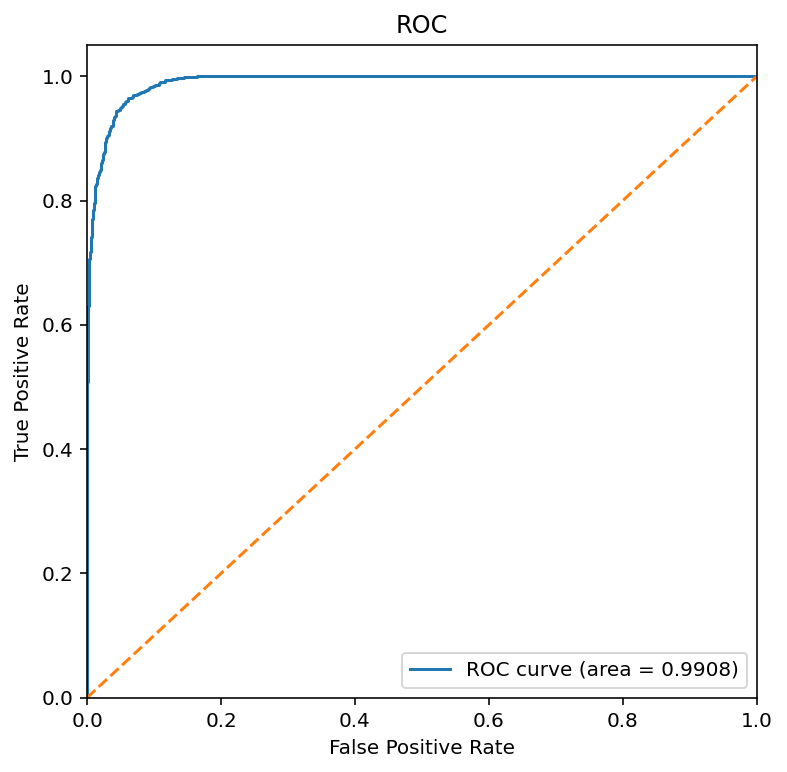

In [52]:
y_score = model.predict_proba(X_test)[:,1]
draw_roc(y_test, y_score)

In [53]:
def draw_PR_curve(y_test, scores):
    prec, rcl, thres = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.figure(figsize=(6,6))
    plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right")

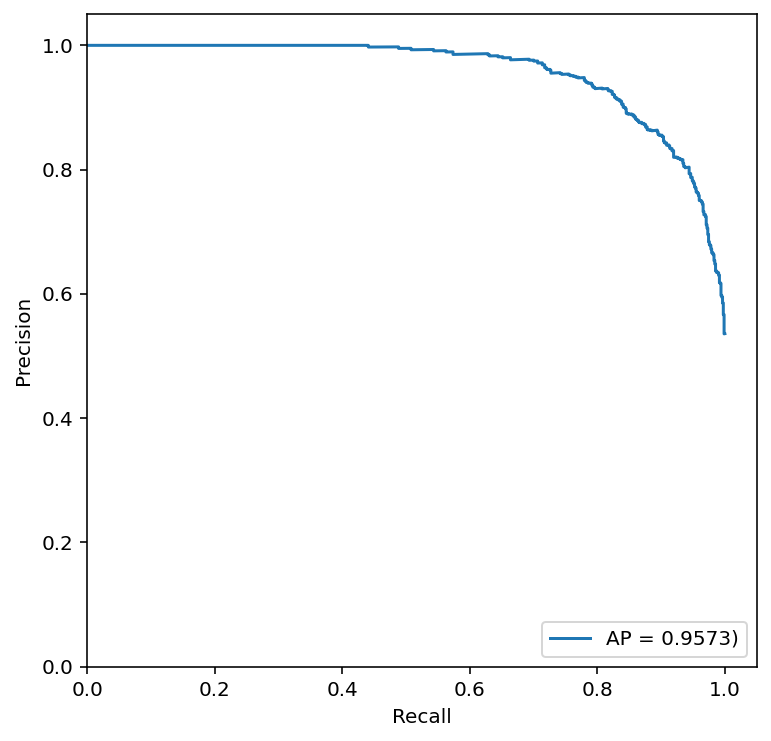

In [54]:
draw_PR_curve(y_test, y_score)

## 랜덤 포레스트

In [144]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

[[4321   72]
 [  99  666]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4393
           1       0.90      0.87      0.89       765

    accuracy                           0.97      5158
   macro avg       0.94      0.93      0.93      5158
weighted avg       0.97      0.97      0.97      5158



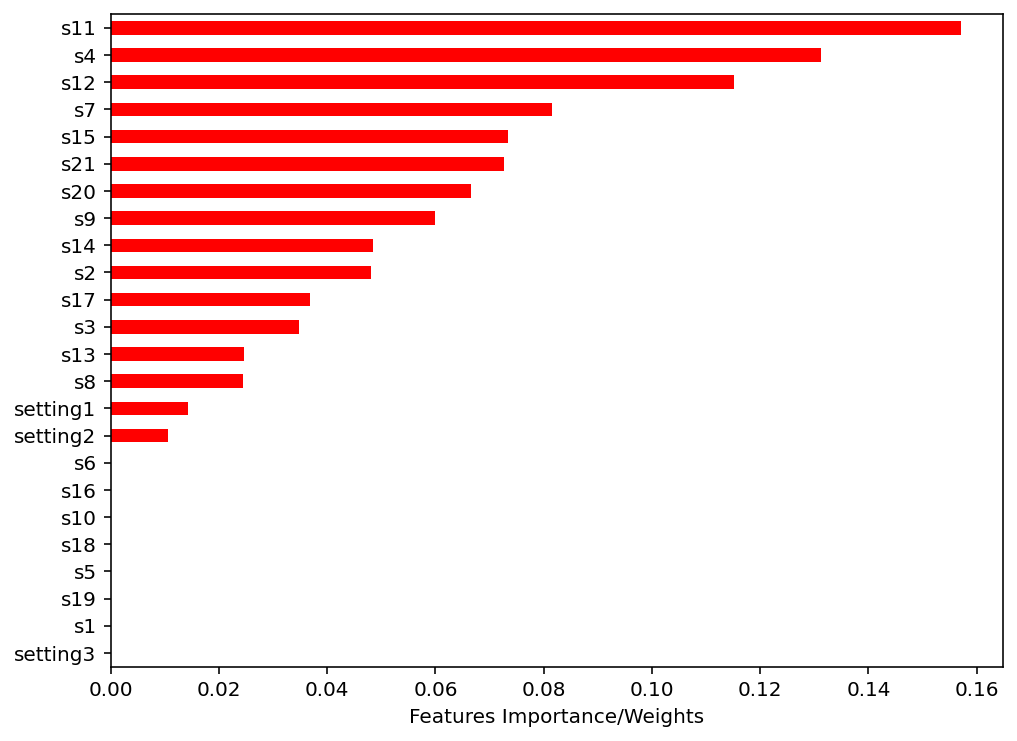

In [145]:
plot_features_weights(X_train.columns, rfc.feature_importances_)

## LightGBM

In [147]:
lgbm_clf = LGBMClassifier(n_estimators=200)
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=5, 
        eval_set=(X_test, y_test), verbose=False)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[4319   74]
 [ 100  665]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4393
           1       0.90      0.87      0.88       765

    accuracy                           0.97      5158
   macro avg       0.94      0.93      0.93      5158
weighted avg       0.97      0.97      0.97      5158



## 분류 기준 시점

- 분류의 경우 분류 기준 시점 선택이 중요하다
 - 고객이 요구하는 시점으로 선택
 - 성능이 가장 잘 나오는 시점을 선택 (실험으로 확인) (성능: 정확도, 리콜, 정밀도, f1 점수 등) 

# 특성 추가 
- 이동평균, 이동분산, 피크수 등의 컬럼을 추가하면 성능이 개선된다 (윈도우 크기 적절하게 선택)
- 특성 선택을 통해서 계산량을 줄일 수 있다
 - 경험으로 선택
 - corr이 큰 특성 선택
 - 선형모델의 coef_, 트리모델의 특성중요도
 - PCA를 사용하여 주성분 수를 줄일 수 있다 (200 --> 20); explained variances --> 1

In [148]:
def rolling_average(df, window):
    df_av = df.rolling(window, min_periods=1).mean()
    df_av.columns = [col + "_av" + str(window) for col in df.columns]
    return df_av
def rolling_std(df, window):
    df_std = df.rolling(window, min_periods=1).std().fillna(0)
    df_std.columns = [col + "_std" + str(window) for col in df.columns]
    return df_std

In [149]:
some_features = ['s12', 's7', 's11']
some_features = ['s12', 's7', 's21', 's20', 's6', 's14', 
     's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']
df2 = df[some_features]
df2

,s12,s7,s21,s20,s6,s14,s9,s13,s8,s3,s17,s2,s15,s4,s11
0,0.633262,0.726248,0.724662,0.713178,1.0,0.199608,0.109755,0.205882,0.242424,0.406802,0.333333,0.183735,0.363986,0.309757,0.369048
1,0.765458,0.628019,0.731014,0.666667,1.0,0.162813,0.100242,0.279412,0.212121,0.453019,0.333333,0.283133,0.411312,0.352633,0.380952
2,0.795309,0.710145,0.621375,0.627907,1.0,0.171793,0.140043,0.220588,0.272727,0.369523,0.166667,0.343373,0.357445,0.370527,0.250000
3,0.889126,0.740741,0.662386,0.573643,1.0,0.174889,0.124518,0.294118,0.318182,0.256159,0.333333,0.343373,0.166603,0.331195,0.166667
4,0.746269,0.668277,0.704502,0.589147,1.0,0.174734,0.149960,0.235294,0.242424,0.257467,0.416667,0.349398,0.402078,0.404625,0.255952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.170576,0.254428,0.109500,0.271318,1.0,0.194344,0.196491,0.558824,0.439394,0.587312,0.750000,0.686747,0.656791,0.782917,0.726190
20627,0.211087,0.162641,0.366197,0.124031,1.0,0.188668,0.194651,0.500000,0.500000,0.729453,0.583333,0.701807,0.727203,0.866475,0.708333
20628,0.281450,0.175523,0.053991,0.232558,1.0,0.212148,0.198196,0.529412,0.515152,0.684979,0.833333,0.665663,0.922278,0.775321,0.738095
20629,0.208955,0.133655,0.234466,0.116279,1.0,0.203065,0.233285,0.514706,0.530303,0.746021,0.583333,0.608434,0.823394,0.747468,0.916667


<AxesSubplot:>

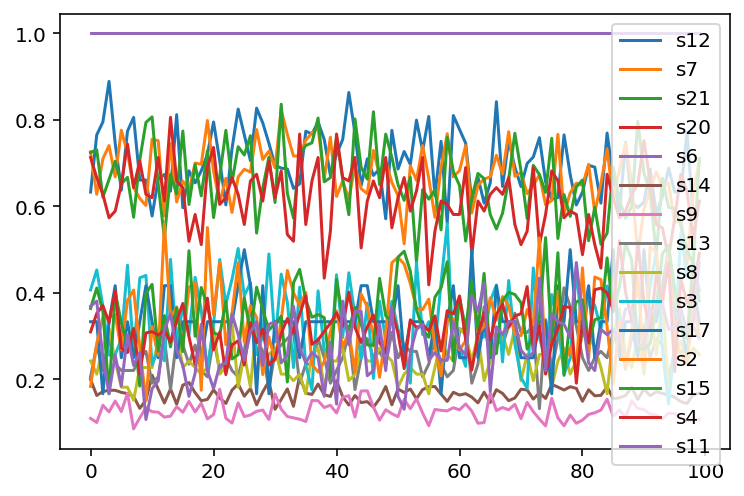

In [151]:
df2[:100].plot()

In [153]:
add1 = rolling_average(df2, 15); add1

,s12_av15,s7_av15,s21_av15,s20_av15,s6_av15,s14_av15,s9_av15,s13_av15,s8_av15,s3_av15,s17_av15,s2_av15,s15_av15,s4_av15,s11_av15
0,0.633262,0.726248,0.724662,0.713178,1.0,0.199608,0.109755,0.205882,0.242424,0.406802,0.333333,0.183735,0.363986,0.309757,0.369048
1,0.699360,0.677134,0.727838,0.689922,1.0,0.181211,0.104999,0.242647,0.227273,0.429911,0.333333,0.233434,0.387649,0.331195,0.375000
2,0.731343,0.688137,0.692350,0.669251,1.0,0.178071,0.116680,0.235294,0.242424,0.409781,0.277778,0.270080,0.377581,0.344306,0.333333
3,0.770789,0.701288,0.684859,0.645349,1.0,0.177276,0.118640,0.250000,0.261364,0.371376,0.291667,0.288404,0.324836,0.341028,0.291667
4,0.765885,0.694686,0.688788,0.634109,1.0,0.176767,0.124904,0.247059,0.257576,0.348594,0.316667,0.300602,0.340285,0.353747,0.284524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.286567,0.281696,0.291365,0.252196,1.0,0.213424,0.201421,0.518627,0.481818,0.614490,0.644444,0.677510,0.684494,0.718647,0.712302
20627,0.281308,0.275148,0.294173,0.246512,1.0,0.211921,0.201867,0.518627,0.485859,0.614766,0.638889,0.677912,0.691779,0.736484,0.723810
20628,0.272353,0.265593,0.281506,0.243928,1.0,0.210834,0.201813,0.519608,0.489899,0.626190,0.655556,0.679518,0.708195,0.737508,0.727381
20629,0.266951,0.254428,0.276084,0.236176,1.0,0.209805,0.204679,0.522549,0.489899,0.635463,0.650000,0.685944,0.718456,0.743856,0.743651


<AxesSubplot:>

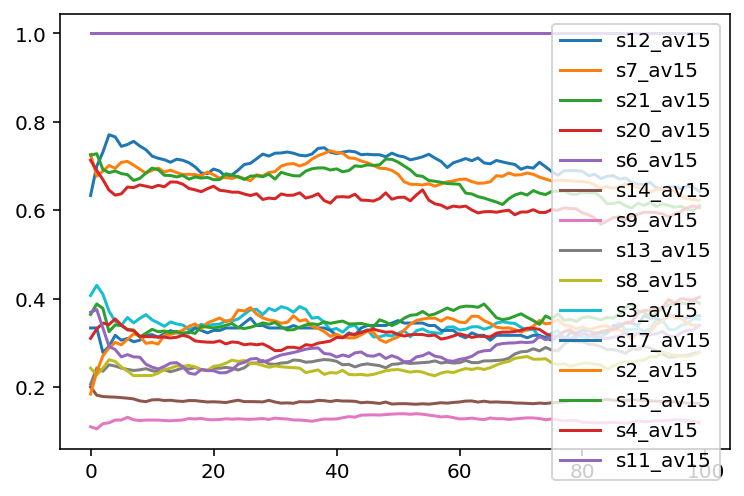

In [154]:
add1[:100].plot()

<AxesSubplot:>

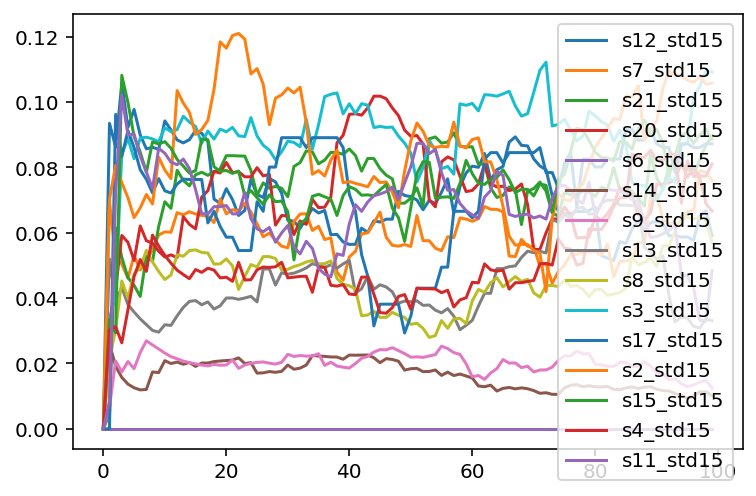

In [155]:
add2 = rolling_std(df2, 15)
add2[:100].plot()

In [156]:
new_df = pd.concat((df[features], add1, add2), axis=1); new_df

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s14_std15,s9_std15,s13_std15,s8_std15,s3_std15,s17_std15,s2_std15,s15_std15,s4_std15,s11_std15
0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,...,0.026018,0.006726,0.051993,0.021427,0.032681,0.000000,0.070285,0.033464,0.030318,0.008418
2,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,...,0.019184,0.020784,0.038908,0.030303,0.041828,0.096225,0.080616,0.029394,0.031229,0.072414
3,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,...,0.015744,0.017417,0.043293,0.045244,0.084062,0.083333,0.075336,0.108185,0.026328,0.102178
4,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,...,0.013682,0.020584,0.038065,0.040087,0.088853,0.091287,0.070716,0.099856,0.036452,0.089918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,1.0,0.254428,...,0.010321,0.012045,0.044628,0.052549,0.093669,0.106657,0.085159,0.087304,0.068841,0.090459
20627,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,1.0,0.162641,...,0.012146,0.011628,0.044628,0.051371,0.094024,0.107583,0.085266,0.085901,0.070252,0.076254
20628,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,1.0,0.175523,...,0.011258,0.011644,0.044697,0.051115,0.091226,0.117289,0.084757,0.104247,0.070729,0.075534
20629,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,1.0,0.133655,...,0.011212,0.013714,0.042646,0.051115,0.096069,0.118690,0.074143,0.107683,0.066689,0.088129


In [71]:
# 중요과제! 앞에서 사용한 24개의 센서 데이터에 특성을 추가하여 X로 사용하면 회귀예측과 분류의 성능이 개선되는지 확인하시오
# R2는 0.62, 정밀도, 리콜은 0.9, 0.83에서 개선되는지 확인
# 위에서는 3개 특성에 대해서 20 사이클 이동평균과 분산을 사용했으나 이를 바꾸어볼 수 있다 (특성 개수나 윈도우 크기)

## 회귀모델
### 랜덤 포레스트

MAE= 15.5518
rmse= 23.6509
max error= 101.64
R2= 0.8811


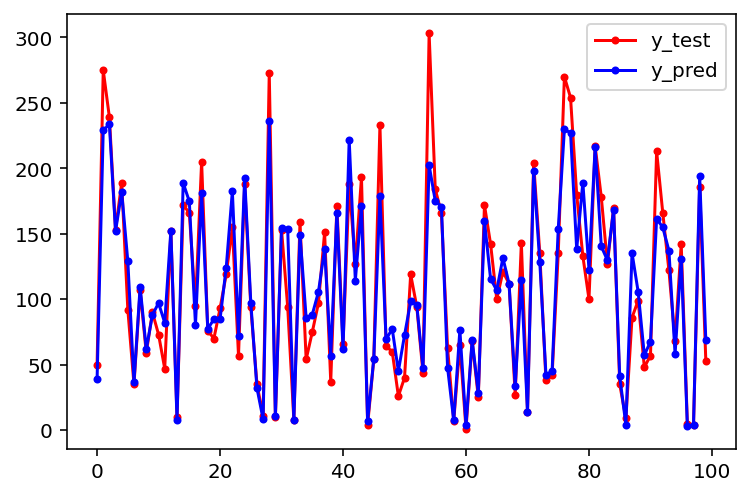

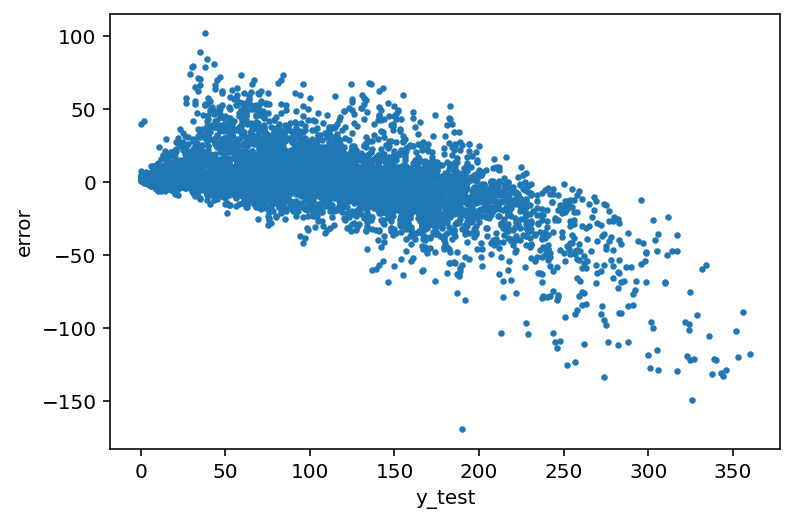

In [157]:
X = new_df
y = df['ttf']
X_train, X_test, y_train, y_test = train_test_split(X, y) # 랜덤하게 섞는다
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
show_regression_result(y_test, y_pred)

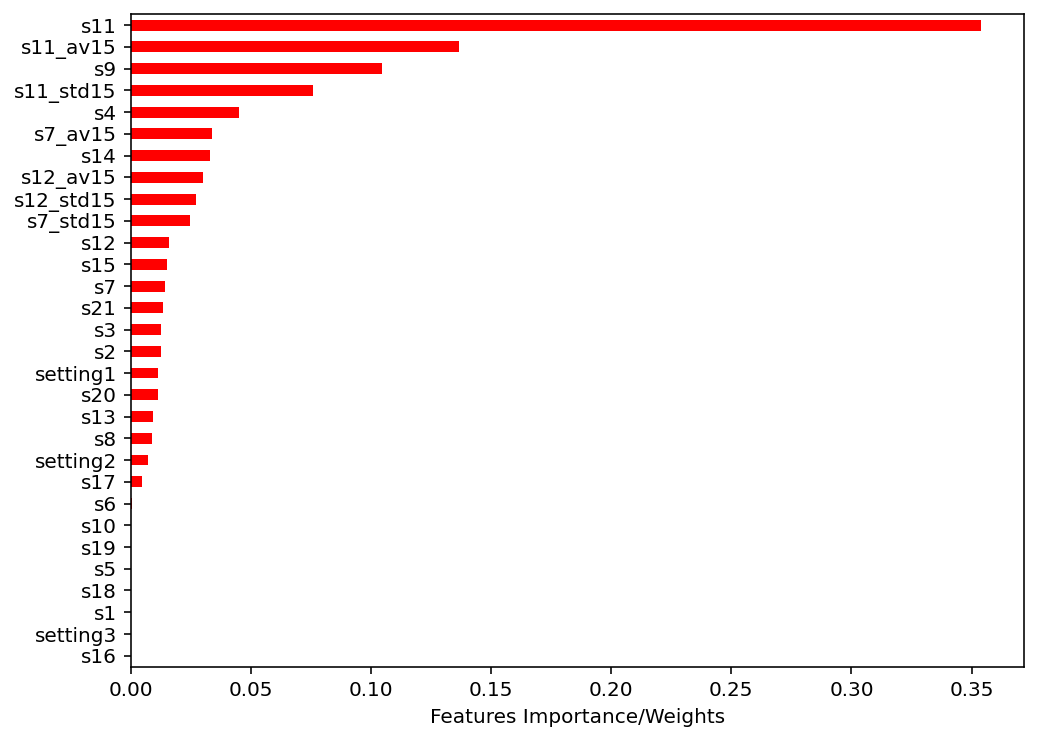

In [73]:
plot_features_weights(X_train.columns, rf.feature_importances_)

### LightGBM

MAE= 16.6972
rmse= 23.8691
max error= 94.5182
R2= 0.8789


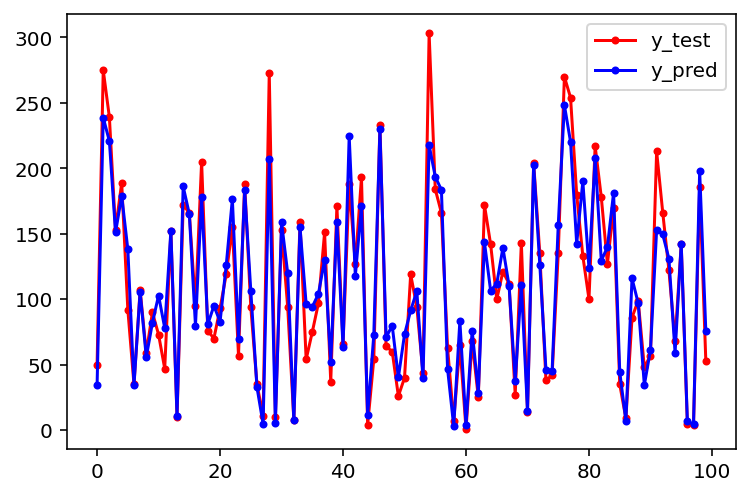

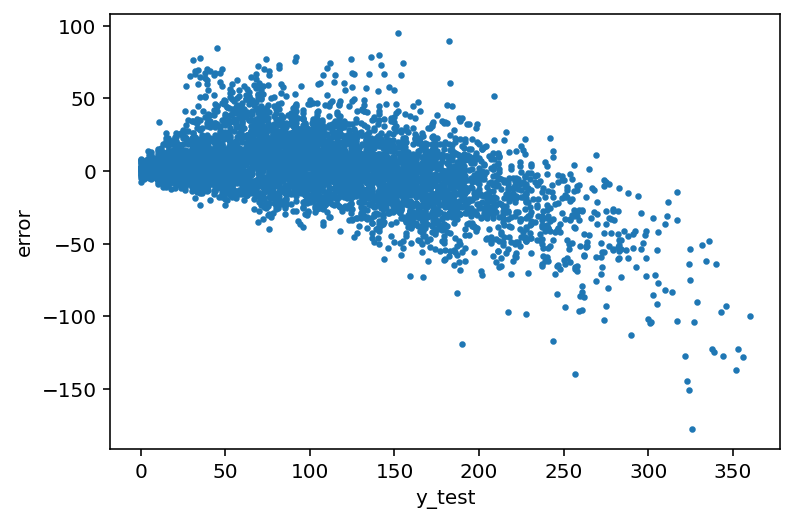

In [159]:
lgbm_r = LGBMRegressor(n_estimators=300)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=10, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred)

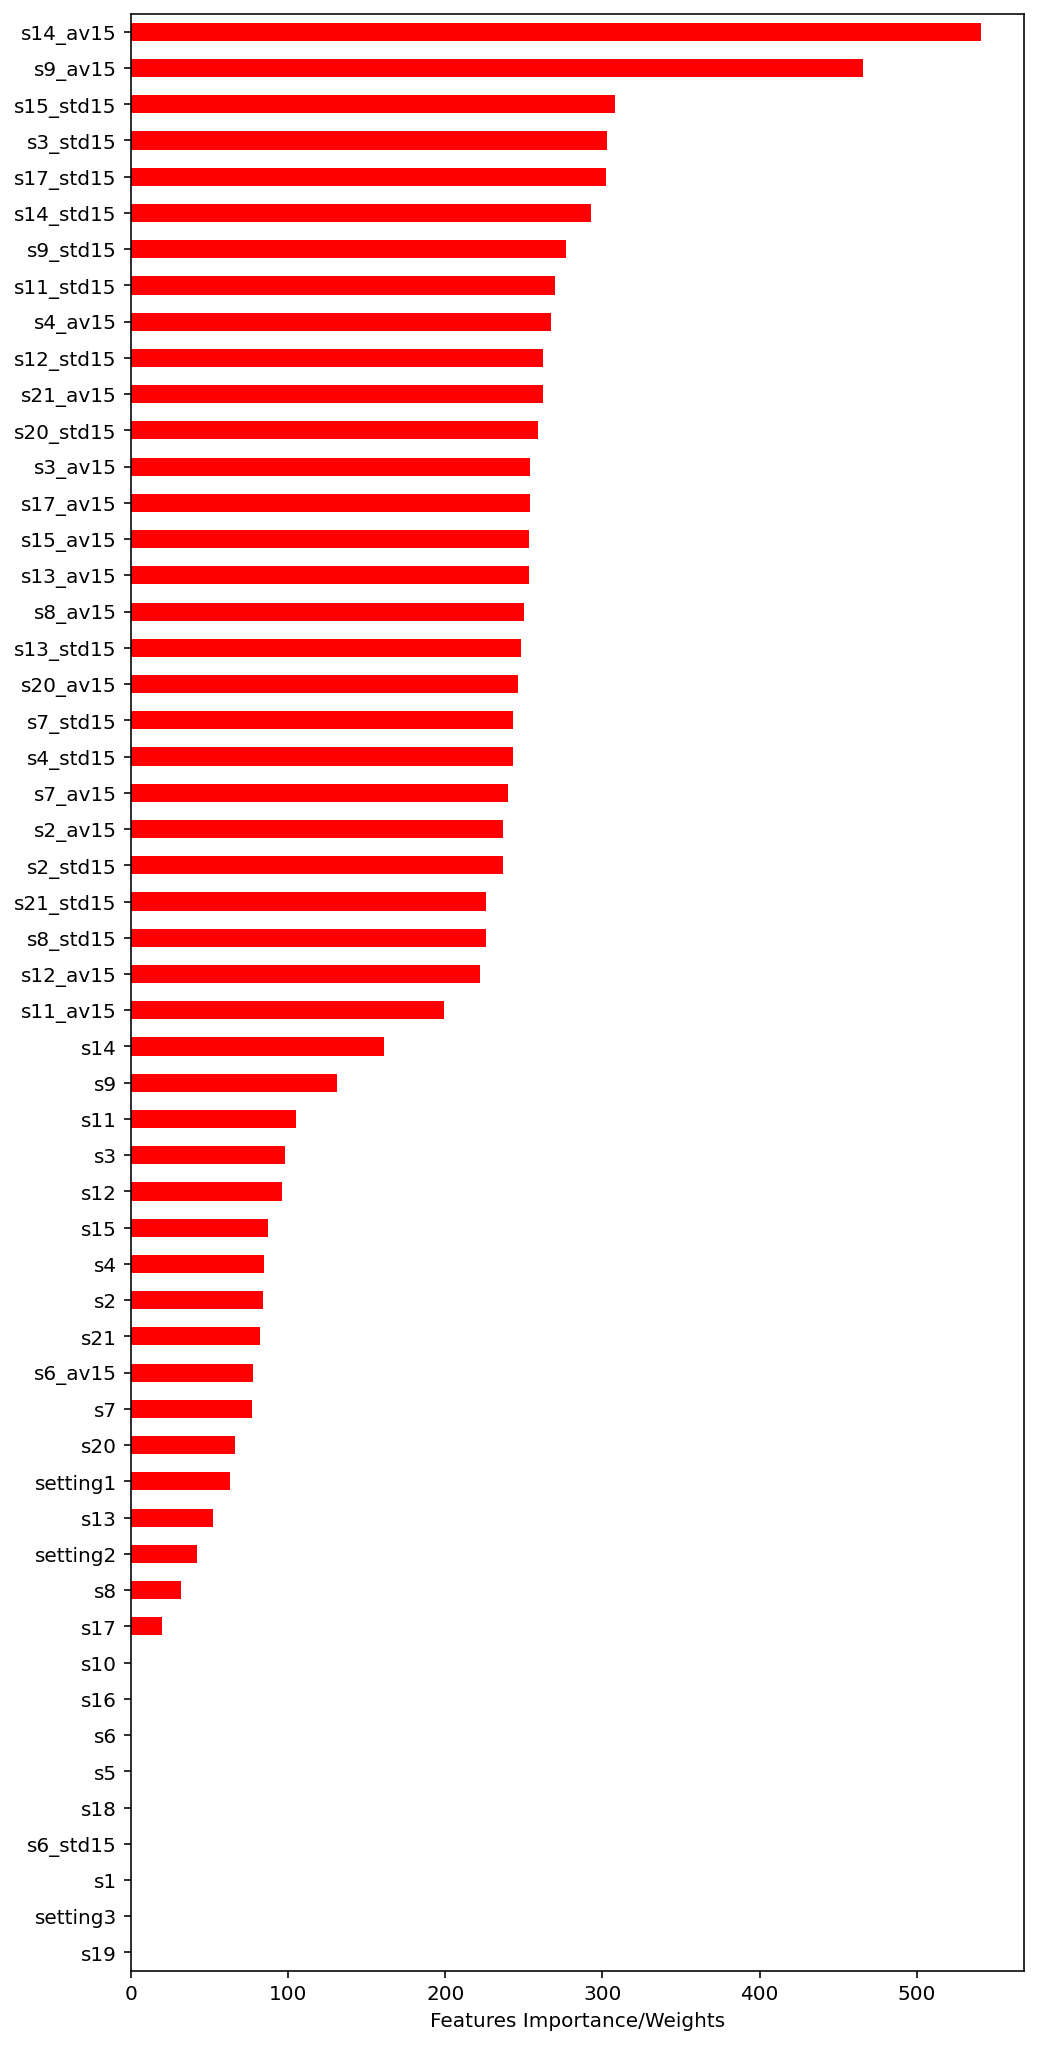

In [160]:
plot_features_weights(X_train.columns, lgbm_r.feature_importances_)


## 분류 모델

### 랜덤 포레스트

In [161]:
X = new_df
y = df['label_bnc']
X_train, X_test, y_train, y_test = train_test_split(X, y) # 랜덤하게 섞는다
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

[[4360   42]
 [  99  657]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4402
           1       0.94      0.87      0.90       756

    accuracy                           0.97      5158
   macro avg       0.96      0.93      0.94      5158
weighted avg       0.97      0.97      0.97      5158



### LightGBM

In [162]:
lgbm_clf = LGBMClassifier(n_estimators=200)
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=5, 
        eval_set=(X_test, y_test), verbose=False)
y_pred = lgbm_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[4368   34]
 [  57  699]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4402
           1       0.95      0.92      0.94       756

    accuracy                           0.98      5158
   macro avg       0.97      0.96      0.96      5158
weighted avg       0.98      0.98      0.98      5158

